In [1]:
from PIL import Image
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor, BlipProcessor, BlipForConditionalGeneration
from qwen_vl_utils import process_vision_info
import gradio as gr
import zipfile
import os
import numpy as np
import random
import shutil
import pandas as pd

c:\Users\archi\anaconda3\envs\asid\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\archi\anaconda3\envs\asid\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\archi\anaconda3\envs\asid\lib\site-packages\torchvision\transfo

In [2]:
# Zipfile path containing data
zipfile_path = os.path.expanduser("~") + '\\ecdna-analysis\\data\\ecSeg_dataset.zip'
zipfile_path

'C:\\Users\\archi\\ecdna-analysis\\data\\ecSeg_dataset.zip'

In [3]:
def convert_tiff_to_png(tiff_path, png_path):
    with Image.open(tiff_path) as img:
        img.save(png_path, 'PNG')

In [4]:
def read_blue_channel(img_path, threshold=30):
    image = Image.open(img_path).convert('RGB')
    res = np.array(image)
    mask = res[:, :, 2] > threshold
    white = np.ones_like(res) * 255
    white[mask] = res[mask]

    result = Image.fromarray(white)

    return result

In [5]:
# zip_file_path = 'C:\\Users\\archi\\ecdna-analysis\\data\\ecSeg_dataset.zip'

# # Folder inside the ZIP file that contains the images
# folder_name = 'train_im/'
# extract_folder = 'train_im_images'

# # Image extensions you want to extract
# image_extensions = ('.jpg', '.jpeg', '.png', '.tif', '.bmp')

# # Open the ZIP file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     all_files = zip_ref.namelist()
    
#     # Filter image files from the specified folder
#     image_files = [f for f in all_files if f.find(folder_name) != -1]
    
#     for image_file in image_files:
#         # Extract the file to the extraction folder
#         zip_ref.extract(image_file, extract_folder)
        
#         # Check if the file is a TIFF image (ends with .tif)
#         if image_file.lower().endswith('.tif'):
#             # Construct the local path for the TIFF file and the destination PNG path
#             extracted_tiff_path = os.path.join(extract_folder, image_file)
#             png_path = os.path.join(extract_folder, f"{os.path.splitext(image_file)[0]}.png")
            
#             # Convert the TIFF to PNG
#             convert_tiff_to_png(extracted_tiff_path, png_path)
            
#             # Optionally, remove the original TIFF file after conversion
#             os.remove(extracted_tiff_path)
#             print(f"Converted {image_file} to PNG.")

#     print(f"Images extracted and converted to PNG in: {extract_folder}")
    
# zip_ref.close()

In [6]:
def generate_random_sample(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    images = [f for f in os.listdir(input_folder)]
    sampled = random.sample(images, 200)

    for image in sampled:
        shutil.copy(os.path.join(input_folder, image), os.path.join(output_folder, image))
        
    return pd.DataFrame(sampled)

In [7]:
input_folder = 'C:/Users/archi/ecdna-analysis/blip/test_im_images/ecSeg_dataset/test_im'
output_folder = 'C:/Users/archi/ecdna-analysis/sampled'
generate_random_sample(input_folder, output_folder)

,0
0,700.png
1,1724.png
2,917.png
3,102.png
4,215.png
...,...
195,1773.png
196,1914.png
197,352.png
198,218.png


In [8]:
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct", torch_dtype="auto", device_map="auto"
)
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct")

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46
Loading checkpoint shards: 100%|██████████| 2/2 [00:07<00:00,  3.84s/it]


In [9]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)


cuda


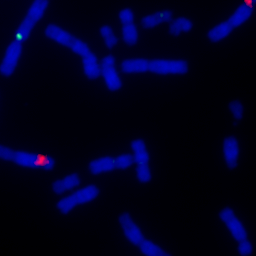

In [10]:
img_num = 2510
img_path = f'C:/Users/archi/ecdna-analysis/blip/train_im_images/ecSeg_dataset/train_im/{str(img_num)}.png'
Image.open(img_path).convert('RGB')

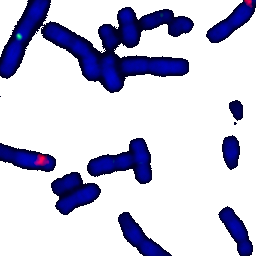

In [11]:
read_blue_channel(img_path)

In [12]:
def generate_history(conversation_history):
    """
        Creates a chat history that is passed as a prompt to the model.
    """
    result = processor.apply_chat_template(conversation_history, tokenize=True, add_generation_prompt=True, return_dict=True, return_tensors="pt")
    return result

def ask_question(conversation_history, device='cuda'):
    """
        Generates the output text given an image and a text prompt.
    """
    processed = generate_history(conversation_history)
    input_ids = processed["input_ids"].to(device)
    response = processor.batch_decode(
        input_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
    )
    return response


def update_conversation_history(role, message, image, conversation_history):
    """
    Updates chat history regular depending on role (User/Agent).
    """
    if role == 'User':
        conversation_history.append(
            {
                "role": role,
                "content": [
                    {
                        "type": "image",
                        "image": image
                    },
                    {
                        "type": "text",
                        "text": message
                    }
                ]
            }
        )
    else:
        conversation_history.append({
            "role": role,
            "content": [
                {"type": "text", "text": message}
            ]
        })
    

def create_chat():
    """
        Simulates a chat between user and AI Agent. Returns chat history.
    """
    conversation_history = []
    print("Welcome to this chat, where you can ask questions to the Qwen2-VL Model! Use Control+C or type 'E' to exit chat.")
    
    while True:
        image_path = input("Enter image path...")
        if not os.path.exists(image_path):
            print("Image path is not valid. Please try again...")
        else:
            break

    while True:
        try:
            while True:
                print("User:", end='')
                prompt = input()
                if not prompt:
                    print("\nError: No prompt provided. Please try again.\n")
                else:
                    break
            
            if prompt == 'E':
                break
            print(' ' + prompt)
            update_conversation_history('User', prompt, image, conversation_history)
            image = Image.open(image_path).convert('RGB')

            response = ask_question(image, conversation_history)[0] or ''
            update_conversation_history('Agent', response, image, conversation_history)
            print(f"Agent: {response}")
        except KeyboardInterrupt:
            print("Chat ended. Thanks for stopping by!")
            break
    
    return conversation_history



In [13]:
create_chat()

Welcome to this chat, where you can ask questions to the Qwen2-VL Model! Use Control+C or type 'E' to exit chat.
User: Descirbe this image


TypeError: sequence item 0: expected str instance, dict found

In [14]:
# Create object anchors around objects of interest